# Adaptive sampling and density-driven art

**Idea**

Most images are not uniform. They have smooth areas (sky, walls, background) and detailed areas (eyes, edges, fur, text).

**Adaptive sampling** fixes that:
- place *many* points where the image has structure,
- place *few* points in flat regions,
- then gently relax points so they spread without losing the density shape,
- and finally render Voronoi or Delaunay art that respects the image.

You can swap images. Try portraits, skylines, animals, or abstract texture.


##  Read the image and measure detail

We start by loading the image and computing two things:

1. **Brightness**  
   - Dark pixels = more detail preserved in shadows and texture  
   - Bright pixels = often smooth, fewer points needed  
   - Here we actually reward *dark* areas by using `1 - brightness`

2. **Edges**  
   - Sobel filters measure how fast brightness changes  
   - Strong edges mark contours and texture that should receive more points

Both terms get normalized into the range `[0,1]`.  
Then we combine them into a single **density** field:

$$ density = 0.6 ⋅(1 - brightness) + 0.4 ⋅ edge $$


- Increase the first weight → more points in dark regions  
- Increase the second weight → sharper outlines


In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests
from scipy import ndimage
from scipy.spatial import Voronoi, Delaunay
from matplotlib import tri as mtri
import matplotlib.colors as clr

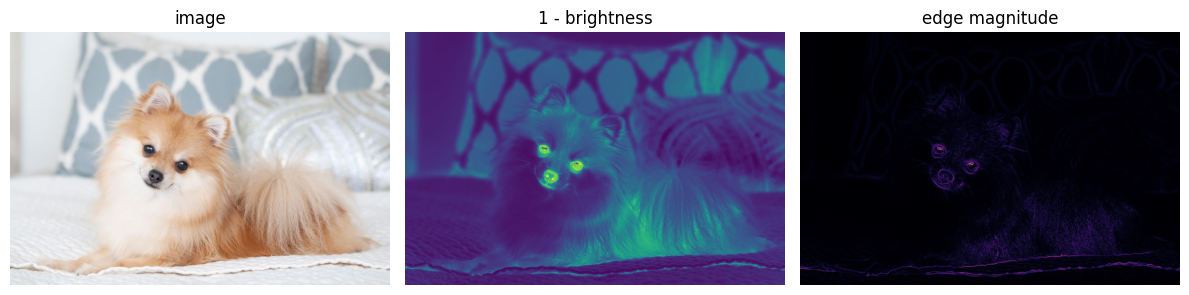

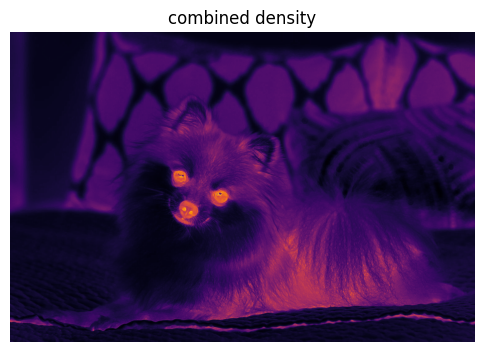

In [ ]:
rng = np.random.default_rng(5)

url = "https://raw.githubusercontent.com/yue-sun/generative-art/main/02_tuesday/puppy.jpg"
img = np.array(Image.open(BytesIO(requests.get(url).content)))
H, W, _ = img.shape
gray = (0.2126*img[...,0] + 0.7152*img[...,1] + 0.0722*img[...,2]) / 255.0

gx = ndimage.sobel(gray, axis=1, mode="reflect")
gy = ndimage.sobel(gray, axis=0, mode="reflect")
edge = np.hypot(gx, gy)
edge = edge / (edge.max() + 1e-8)

w_brightness = 0.6
w_edge = 0.4
brightness_term = 1.0 - gray
density = w_brightness*brightness_term + w_edge*edge
density = np.clip(density, 1e-12, None)
p = density / density.sum()

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(img); axes[0].set_title("image"); axes[0].axis('off')
axes[1].imshow(brightness_term, cmap="viridis"); axes[1].set_title("1 - brightness"); axes[1].axis('off')
axes[2].imshow(edge, cmap="magma"); axes[2].set_title("edge magnitude"); axes[2].axis('off')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,6))
plt.imshow(density, cmap="inferno"); plt.title("combined density"); plt.axis('off'); plt.show()

##  Sampling points from the density field

We treat the image as a grid of `H × W` bins.  
Each pixel becomes a bin with a probability proportional to `density`.

Sampling process:
1. Flatten the density into a 1-D probability list
2. Draw random indices using `rng.choice`
3. Convert indices back to `(x, y)` coordinates
4. Add a small random jitter so points do not stack at exact pixel centers

Result: many points in detailed zones, few points elsewhere.

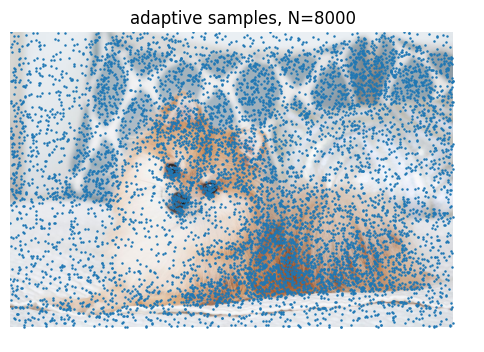

In [ ]:
def sample_points_from_density(p, N, rng):
    h, w = p.shape
    idx = rng.choice(h*w, size=N, replace=True, p=p.ravel())
    ys, xs = np.divmod(idx, w)
    xs = xs + rng.random(N)
    ys = ys + rng.random(N)
    return np.column_stack([xs, ys])

N_points = 8000
pts = sample_points_from_density(p, N_points, rng)

plt.figure(figsize=(6,6))
plt.imshow(img); plt.scatter(pts[:,0], pts[:,1], s=0.6)
plt.title(f"adaptive samples, N={N_points}")
plt.axis('off'); plt.show()


## A tiny Lloyd relaxation

Raw adaptive samples can create small clumps.  
A short relaxation improves spacing **without erasing the density pattern**.

- We build a Voronoi diagram
- Replace each generator with its Voronoi cell centroid
- Keep only cells fully inside the image bounds (ignore unbounded regions)
- 1–2 iterations are enough

Too many iterations will drift back toward a uniform grid — avoid that.

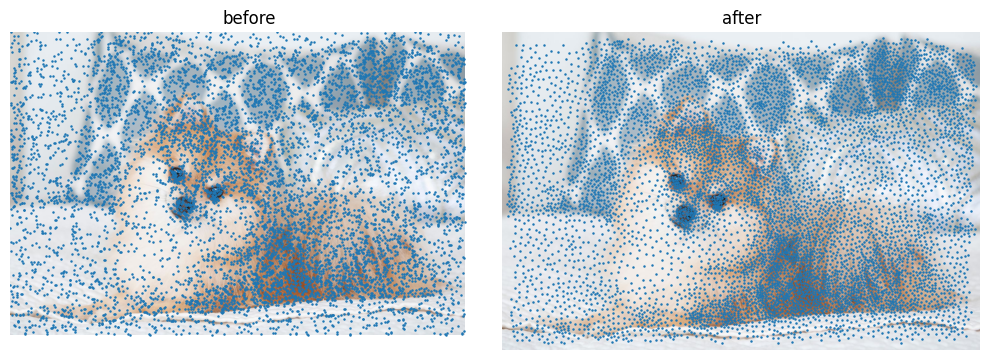

In [ ]:
# very light relaxation to reduce clumping while keeping density intent
def polygon_centroid(poly):
    x, y = poly[:,0], poly[:,1]
    A = 0.5*np.sum(x*np.roll(y,-1) - np.roll(x,-1)*y)
    if abs(A) < 1e-10:
        return poly.mean(axis=0)
    cx = np.sum((x+np.roll(x,-1))*(x*np.roll(y,-1)-np.roll(x,-1)*y)) / (6*A)
    cy = np.sum((y+np.roll(y,-1))*(x*np.roll(y,-1)-np.roll(x,-1)*y)) / (6*A)
    return np.array([cx, cy])

def lloyd_box_step(P, W, H):
    V = Voronoi(P)
    out = []
    for r in V.point_region:
        region = V.regions[r]
        if not region or (-1 in region):
            continue
        poly = V.vertices[region]
        if (poly[:,0].min()<0) or (poly[:,0].max()>W) or (poly[:,1].min()<0) or (poly[:,1].max()>H):
            continue
        out.append(polygon_centroid(poly))
    return np.array(out) if len(out) > 50 else P

relaxed = pts.copy()
for _ in range(2):
    relaxed = lloyd_box_step(relaxed, W, H)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img); axes[0].scatter(pts[:,0], pts[:,1], s=0.6); axes[0].set_title("before"); axes[0].axis('off')
axes[1].imshow(img); axes[1].scatter(relaxed[:,0], relaxed[:,1], s=0.6); axes[1].set_title("after"); axes[1].axis('off')
plt.tight_layout(); plt.show()

## Voronoi mosaic

Each point becomes a generator of a Voronoi cell.
We fill each polygon with the color sampled at that generator.

What you should see:
- Large polygons in smooth areas
- Tiny polygons in detailed areas
- Sharp outlines and well-preserved features

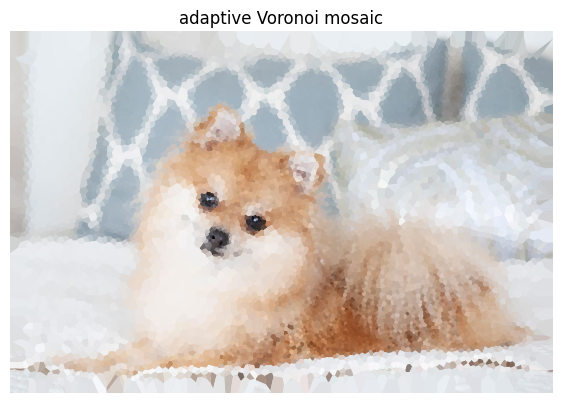

In [ ]:
# Voronoi mosaic
V = Voronoi(relaxed)
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(img)
for i, r in enumerate(V.point_region):
    region = V.regions[r]
    if not region or (-1 in region):
        continue
    poly = V.vertices[region]
    if poly.size == 0:
        continue
    px = int(np.clip(relaxed[i,0], 0, W-1))
    py = int(np.clip(relaxed[i,1], 0, H-1))
    ax.fill(*zip(*poly), color=(img[py,px]/255.0), linewidth=0)
ax.set_xlim(0,W); ax.set_ylim(H,0); ax.axis('off')
ax.set_title("adaptive Voronoi mosaic")
plt.show()


##  Delaunay mesh (smooth shading)

Delaunay triangulation connects the points into triangles.
We color each triangle by averaging its vertex colors.

- Dense areas → many small triangles → smooth shading
- Flat areas → big triangles → graphic, poster-like feel
- Works especially well on portraits or architecture

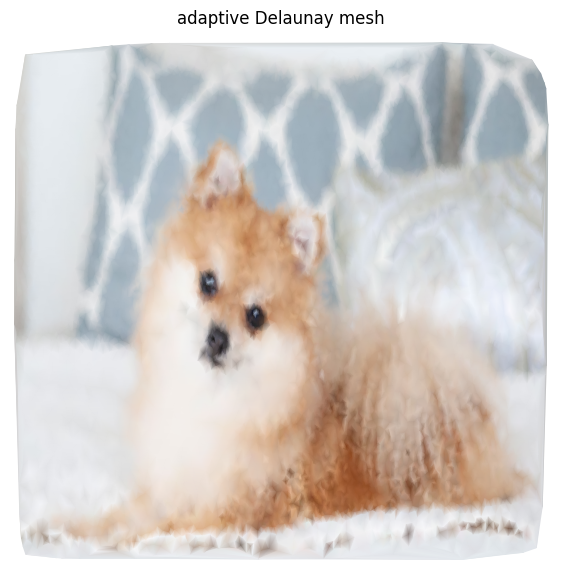

In [ ]:
# Delaunay smooth shading
tri = Delaunay(relaxed)
ver_rgb = np.zeros((len(relaxed),3))
for i,(x,y) in enumerate(relaxed):
    px = int(np.clip(x,0,W-1)); py = int(np.clip(y,0,H-1))
    ver_rgb[i] = img[py,px]/255.0

z = np.arange(len(ver_rgb))
cmap = clr.LinearSegmentedColormap.from_list("mymap", ver_rgb, N=len(ver_rgb))
triang = mtri.Triangulation(relaxed[:,0], relaxed[:,1], tri.simplices)

fig, ax = plt.subplots(figsize=(7,7))
ax.tripcolor(triang, z, shading="gouraud", cmap=cmap)
ax.set_xlim(0,W); ax.set_ylim(H,0); ax.axis('off')
ax.set_title("adaptive Delaunay mesh")
plt.show()


## Try this!

- Swap in a high-contrast portrait or skyline
- Increase `w_edge` for sharper outlines
- Increase `N_points` for finer detail, decrease for a blocky look
- Remove relaxation entirely for a grainy, stippled texture
- Save your best mosaics for the gallery